# Ocean iron concentration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client

import catalog
import util

xr.set_options(keep_attrs=True)

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [38]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
import pandas as pd
import tools
import plot
import matt_utils
import matplotlib.gridspec as gridspec
import numpy as np
from itertools import product
import cmocean
import matplotlib.colors as colors

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

### Parameters

In [5]:
casename = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'
component = 'pop'
stream = 'h'

cluster_scheduler_address = None

In [6]:
assert component in ['pop']
assert stream in ['h', 'h.ecosys.nday1']

### Connect to cluster

In [7]:
if cluster_scheduler_address is None:
    cluster, client = util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41231 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/41231/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/41231/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:44413,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/41231/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data

In [42]:
dsets = catalog.to_dataset_dict(
    case=casename,
    component=component,
    stream=stream,
)
dsets.keys()

dict_keys(['g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1.pop.h'])

### Compute long-term mean Fe concentration

In [9]:
ds = dsets[f'{casename}.{component}.{stream}']

In [10]:
variables =['Fe']

In [11]:
keep_vars=['z_t','z_t_150m','dz','time_bound','TAREA','TLAT','TLONG'] + variables
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

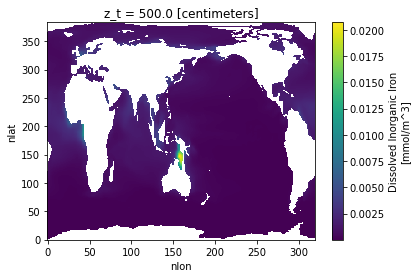

In [12]:
ds.Fe.isel(time=0,z_t=0).plot()

In [43]:
dt_wgt = ds.time_bound.diff('d2').squeeze()
dt_wgt /= dt_wgt.sum()
#dt_wgt

In [15]:
ds = ds.weighted(dt_wgt).mean('time')

In [31]:
nmolcm3_to_nM = 1.e3
ds['Fe'] = ds['Fe'] * nmolcm3_to_nM
ds['Fe'].attrs['units'] = 'nM'

### Compare to observational Fe database

(need ref)

In [32]:
dFe_obs_file = '/glade/u/home/kristenk/cesm2-marbl/notebooks/discrete_obs/dFe-database-2021-05-20.csv'
df = pd.read_csv(dFe_obs_file, na_values=-999.).dropna(axis=0, how='all')

In [33]:
%%time
df.obs_stream.add_model_field(ds.Fe)
df

CPU times: user 1min 58s, sys: 4.42 s, total: 2min 3s
Wall time: 6min 57s


,lon,lat,depth,dFe_obs,Fe
0,210.010,-16.0018,20.0,0.540000,0.047255
1,210.010,-16.0018,35.0,0.440000,0.047110
2,210.010,-16.0019,50.0,0.480000,0.046569
3,210.010,-16.0019,80.0,0.400000,0.044805
4,210.010,-16.0020,100.0,0.390000,0.048094
...,...,...,...,...,...
27777,160.051,47.0032,3929.6,0.825681,0.466740
27778,160.051,47.0032,3929.8,0.902248,0.466748
27779,160.051,47.0032,4900.4,0.555630,NaN
27780,160.051,47.0032,4900.9,0.621851,NaN


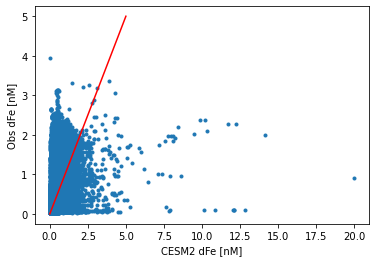

In [34]:
plt.plot(df.dFe_obs, df.Fe, '.')
plt.xlabel('CESM2 dFe [nM]')
plt.ylabel('Obs dFe [nM]')
plt.plot([0, 5], [0, 5], 'r-')

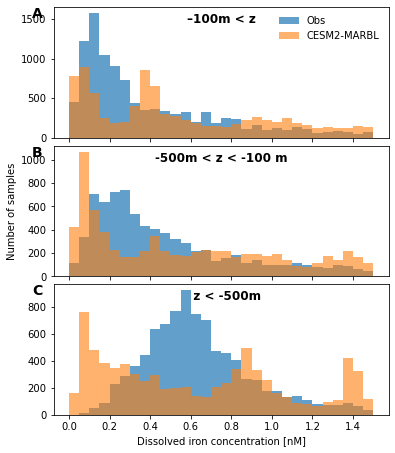

In [37]:
fig, axs = plot.canvas(3, 1, figsize=(6, 2.5), use_gridspec=True, hspace=0.06)

dx = 0.05
bin_edges = np.arange(0., 1.5+dx, dx)
bins = np.vstack((bin_edges[:-1], bin_edges[1:])).mean(axis=0)

depth_ranges = {
    '–100m < z': (0., 100.),
    '-500m < z < -100 m': (100., 500.),
    '   z < -500m': (500., 1e36),
}

for n, (key, depth_range) in enumerate(depth_ranges.items()):
    ax = axs[n, 0]
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    
    hist, _ = np.histogram(df_sub.dFe_obs.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.7, label='Obs')
    
    hist, _ = np.histogram(df_sub.Fe.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.6, label='CESM2-MARBL')
    
    if n == 0:
        ax.legend(loc='upper right', frameon=False)
    if n < 2:
        ax.set_xticklabels([])
    ylm = ax.get_ylim()
    ax.text(0.75, ylm[1] - 0.12 * np.diff(ylm), key, 
            fontweight='bold',
            fontsize=12,
            ha='center',
           )
    if n == 1:
        ax.set_ylabel('Number of samples')
    if n == 2:
        ax.set_xlabel('Dissolved iron concentration [nM]')
        
matt_utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.05, yoff=-0.02)

In [40]:
dsp = matt_utils.pop_add_cyclic(ds)

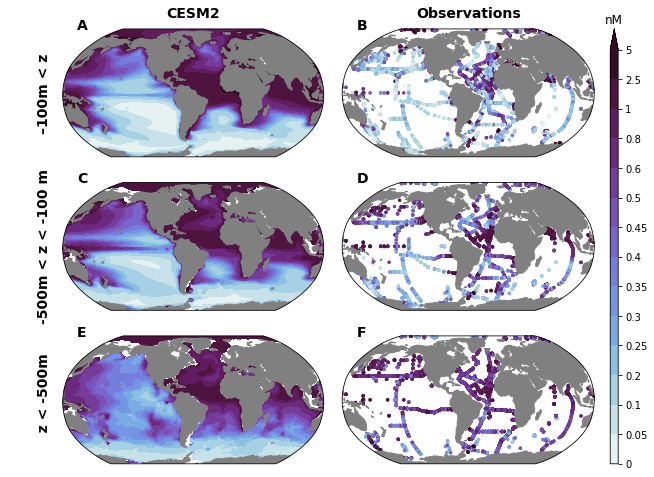

In [41]:
field = 'Fe'
levels = {'Fe': [0., 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1., 2.5, 5.0]}

fig = plt.figure(figsize=(10, 8))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 3, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.03),
    wspace=0.05, 
    hspace=0.2,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
cax = plt.subplot(gs[:, -1])

cmap_field = cmocean.cm.dense


for i, (key, depth_range) in enumerate(depth_ranges.items()):
    for j in range(2):
        ax = axs[i, j]
        if j == 0:
            zslice = slice(depth_range[0]*100., depth_range[1]*100.)

            cf = ax.contourf(
                dsp.TLONG,dsp.TLAT, dsp[field].sel(z_t=zslice).mean('z_t'),
                levels=levels[field],
                extend='max',
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                transform=ccrs.PlateCarree(),
            )
        else:
            df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
            sc = ax.scatter(
                df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                s=6,
                transform=ccrs.PlateCarree(),
            )

        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )  

cb = plt.colorbar(cf, cax=cax, ticks=levels['Fe'])
if 'units' in dsp[field].attrs:
    cb.ax.set_title(dsp[field].attrs['units'])
    cb.ax.set_yticklabels([f'{f:g}' for f in levels['Fe']])

matt_utils.subplot_col_labels(axs[0, :], ['CESM2', 'Observations'])    
matt_utils.subplot_row_labels(axs[:, 0], depth_ranges.keys(), xoff=60)
    
matt_utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0) 